In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hydrophone_data_processing import load, preprocessing
import glob
import obspy

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.io.img_tiles as cimgt

import gc

inventory = obspy.read_inventory('fdsn-station_2021-06-29T11_00_50.xml', format="STATIONXML")
channels = inventory.networks[0].get_contents()['channels']
networkdf = pd.DataFrame([inventory.get_coordinates(seed_id=id) for id in channels], index=[id for id in channels])
networkdf['station'] = [c.split('.')[1] for c in channels]
networkdf['component'] = [c.split('.')[-1] for c in channels]

In [2]:
stations = !ls /media/sda/data/robdata/PASSCAL/Main_deployment/DAYS/

In [3]:
station_list = ['B19', 'B20', 'B07', 'B03', 'B15', 'A19', 'A18', 'A02', 'A15']
dataloc = '/media/sda/data/robdata/PASSCAL/Main_deployment/DAYS/'


# paths = np.array([glob.glob(dataloc+station+'/*GHZ*.011') for station in station_list]).flatten()
paths = [glob.glob(dataloc+station+'/*GHZ*.011') for station in stations]
for i, p in enumerate(paths):
    if len(p) == 0:
        paths.pop(i)
paths = np.array(paths).flatten()

In [4]:
import gc
help(gc.collect)

Help on built-in function collect in module gc:

collect(generation=2)
    Run the garbage collector.
    
    With no arguments, run a full collection.  The optional argument
    may be an integer specifying which generation to collect.  A ValueError
    is raised if the generation number is invalid.
    
    The number of unreachable objects is returned.



In [5]:
stream = load.get_raw_stream(paths)
# s = obspy.UTCDateTime('2020-01-11T14:50:00')
# e = obspy.UTCDateTime('2020-01-11T15:07:00')
# x = stream.plot(starttime=s, endtime=e)

In [6]:
stream.decimate(factor=2)

38 Trace(s) in Stream:

7F.A12..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.998000Z | 500.0 Hz, 43200000 samples
...
(36 other traces)
...
7F.B20..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.998000Z | 500.0 Hz, 43200000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [7]:
stream.detrend('demean')

38 Trace(s) in Stream:

7F.A12..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.998000Z | 500.0 Hz, 43200000 samples
...
(36 other traces)
...
7F.B20..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.998000Z | 500.0 Hz, 43200000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [8]:
stream.filter(type='highpass', corners=4, freq=40, zerophase=True)

38 Trace(s) in Stream:

7F.A12..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.998000Z | 500.0 Hz, 43200000 samples
...
(36 other traces)
...
7F.B20..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.998000Z | 500.0 Hz, 43200000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [9]:
# stream.decimate(factor=5)
# preprocessing.square_stream(stream)
for tr in stream:
    tr.data = np.abs(tr.data)
stream.decimate(factor=5, no_filter=True)

38 Trace(s) in Stream:

7F.A12..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.990000Z | 100.0 Hz, 8640000 samples
...
(36 other traces)
...
7F.B20..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.990000Z | 100.0 Hz, 8640000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [10]:
stream

38 Trace(s) in Stream:

7F.A12..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.990000Z | 100.0 Hz, 8640000 samples
...
(36 other traces)
...
7F.B20..BHZ | 2020-01-11T00:00:00.000000Z - 2020-01-11T23:59:59.990000Z | 100.0 Hz, 8640000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [11]:
# s = obspy.UTCDateTime('2020-01-11T14:50:00')
# e = obspy.UTCDateTime('2020-01-11T15:07:00')
# # x = stream.plot(starttime=s, endtime=e)
# x = stream.plot()

In [12]:
# w[0].stats

In [13]:
# stream.traces[0].stats

In [14]:
windows = stream.slide(window_length=10, step=10)

maxamp_df = pd.DataFrame()

for window in windows:
    stations = [tr.stats.station for tr in window]
    ampmax = window.max()
    row = dict(zip(stations, ampmax))
    wdf = pd.DataFrame(row, index=[pd.to_datetime(str(window[0].stats.starttime))])
    maxamp_df = pd.concat([maxamp_df, wdf])

In [15]:
# x = [row for row in maxamp_df.iterrows()]

In [16]:
# x[0]

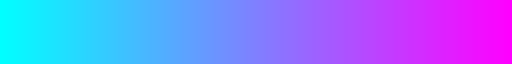

In [17]:
import matplotlib
cmap = matplotlib.cm.cool
cmap

In [18]:
# # label the markers
# for row in networkdf.iterrows():
#     row = row[1]
#     name = row.name.split('.')[1]
#     # print(name)
#     lat = row.latitude
#     lon = row.longitude
#     ax.text(s=name, x=lon, y=lat, fontsize=15)
# # ax.text(s='ZZZZZ', x=networkdf.longitude[0]-0.0005, y=networkdf.latitude[0])

def make_map(lats, lons, maxamps, timeindex, debug=True, fileloc=''):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.axis('off')

    proj = ccrs.PlateCarree()
    ax = plt.axes(projection=proj)
    ax.coastlines(resolution='110m')
    gl = ax.gridlines(crs=ccrs.PlateCarree()        
                    , draw_labels=True
                    , linewidth=2
                    , color='gray'
                    , alpha=0.5
                    , linestyle='--')
    gl.xlabel_style = {'size': 15}                                     # change label font sizes
    gl.ylabel_style = {'size': 15}
    cmaps = cmap(np.log10(maxamps)/np.log10(maxamp_df.max()))
    # for c, lon, lat in zip(cmap(maxamps/maxamp_df.max()), lons, lats):
    for c, lon, lat in zip(cmaps, lons, lats):
        # ax.plot(lon, lat, marker='o', markersize=20, color=cmap(maxamps/maxamp_df.max())[0])
        ax.plot(lon, lat, marker='o', markersize=20, color=c)
        
        
    if debug == False:
        fig.savefig(fileloc+'{}.png'.format(timeindex), dpi=150, bbox_inches='tight')
        plt.clf()
        plt.close(fig)
        del fig, ax, proj, gl, cmaps, c, lon, lat
        gc.collect()

# timeindex = 300
# row = maxamp_df.iloc[timeindex]
# lons = networkdf[networkdf.station.isin(row.index) & (networkdf.component=='GHZ')].longitude
# lats = networkdf[networkdf.station.isin(row.index) & (networkdf.component=='GHZ')].latitude
# for n in np.arange(0, 100, 1):
#     make_map(lats=lats, lons=lons, timeindex=timeindex, maxamps=row, debug=False)
# else:
#     print('done')

In [19]:
def do(row):
    row = row[1]
    lons = networkdf[networkdf.station.isin(row.index) & (networkdf.component=='GHZ')].longitude
    lats = networkdf[networkdf.station.isin(row.index) & (networkdf.component=='GHZ')].latitude
    make_map(lats=lats, lons=lons, timeindex=row[0], maxamps=row, debug=False, fileloc='/media/sda/data/borehole/maps/')
    del row, lons, lats

In [ ]:
from multiprocessing import Pool

rows = [row for row in maxamp_df.iterrows()]

pool = Pool(10)
pool.map(do, rows)
pool.close()
print('check your maps motherfucker')

In [ ]:
# for i, row in enumerate(maxamp_df.iterrows()):
#     row = row[1]
#     lons = networkdf[networkdf.station.isin(row.index) & (networkdf.component=='GHZ')].longitude
#     lats = networkdf[networkdf.station.isin(row.index) & (networkdf.component=='GHZ')].latitude
#     make_map(lats=lats, lons=lons, timeindex=i, maxamps=row, debug=False, fileloc='/media/sda/data/borehole/maps/')

In [ ]:
# print('check out your maps motherfucker')

In [ ]:
# for row in maxamp_df.iterrows():
#     for i in row.index:
#         lat = networkdf[networkdf.station==i].latitude.values[0]
#         lon = networkdf[networkdf.station==i].longitude.values[0]
#         # maxamp = row.loc[i]
#         # del lat, lon, maxamp



In [ ]:
# a02 = stream[0]
# a15 = stream[1]
# a18 = stream[2]
# a19 = stream[3]
# b03 = stream[4]
# b07 = stream[5]
# b15 = stream[6]
# b19 = stream[7]
# b20 = stream[8]

# ordered = [b20, b07, b03, b15, b19, a19, a18, a02, a15, ]

In [ ]:
# networkdf.sort_values(by=['latitude', 'longitude'])

In [ ]:
# len(ordered)

In [ ]:
# fig, ax = plt.subplots(len(ordered), 1, figsize=(15, 15), sharex=True)

# for i, tr in enumerate(ordered):
#     ax[i].plot(tr.times(), tr.data)
#     ax[i].set_yscale('log')